# Random Variables

In [1]:
%matplotlib inline
import itertools as it
import re
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats
import toolz as tz

In [2]:
import seaborn as sns
from numba import jit

## Why are random numbers useful?

If we can draw an arbitrary number of random deviates from a distribution, in some sense, we know everything there is to know about the distribution.

## Where do random numbers in the computer come from?

While psuedorandom numbers are generated by a deterministic algorithm, we can mostly treat them as if they were true random numbers and we will drop the "pseudo" prefix. Fundamentally, the algorithm generates random integers which are then normalized to give a floating point number from the standard uniform distribution. Random numbers from other distributions are in turn generated using these uniform random deviates, either via general (inverse transform, accept/reject, mixture representations) or specialized ad-hoc (e.g. Box-Muller) methods.

### Generating standard uniform random numbers

#### Linear congruential generators (LCG)

$z_{i+1} = (az_i + c) \mod m$

Hull-Dobell Theorem: The LCG will have a full period for all seeds if and only if

- $c$ and $m$ are relatively prime,
- $a - 1$ is divisible by all prime factors of $m$
- $a - 1$ is a multiple of 4 if $m$ is a multiple of 4.

The number $z_0$ is called the *seed*, and setting it allows us to have a reproducible sequence of "random" numbers. The LCG is typically coded to return $z/m$, a floating point number in (0, 1). This can be scaled to any other range $(a, b)$.

Note that most PRNGs now use the [Mersenne twister](http://www.math.sci.hiroshima-u.ac.jp/~m-mat/MT/ARTICLES/mt.pdf), but the LCG is presented because the LCG code much easier to understand and all we hope for is some appreciation for how apparently random sequences can be generated from a deterministic iterative scheme.

In [3]:
def lcg(m=2**32, a=1103515245, c=12345):
    lcg.current = (a*lcg.current + c) % m
    return lcg.current/m

In [4]:
# setting the seed
lcg.current = 1

In [5]:
[lcg() for i in range(10)]

[0.25693503906950355,
 0.5878706516232342,
 0.15432575810700655,
 0.767266943352297,
 0.9738139626570046,
 0.5858681506942958,
 0.8511155843734741,
 0.6132153405342251,
 0.7473867232911289,
 0.06236015981994569]

### Inverse transform method

Once we have standard uniform numbers, we can often generate random numbers from other distribution using the inverse transform method. Recall that if $X$ is a continuous random variable with CDF $F_X$, then $Y = F_X(X)$ has the standard uniform distribution. Inverting this suggests that if $Y$ comes from a standard uniform distribution, then $F_X^{-1}(Y)$ has the same distribution as $X$. The inverse transform method is used below to generate random numbers from the exponential distribution.

In [6]:
def expon_pdf(x, lmabd=1):
    """PDF of exponential distribution."""
    return lmabd*np.exp(-lmabd*x)

def expon_cdf(x, lambd=1):
    """CDF of exponetial distribution."""
    return 1 - np.exp(-lambd*x)

def expon_icdf(p, lambd=1):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-p)/lambd

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


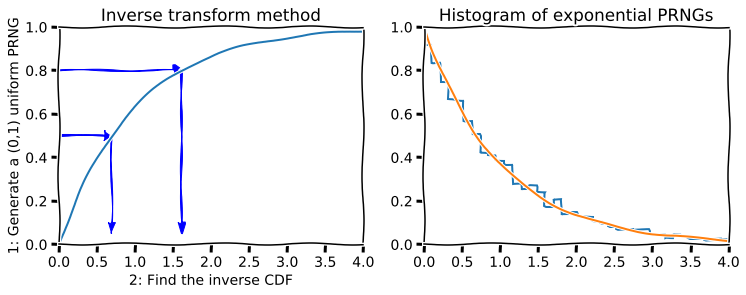

In [7]:
import scipy.stats as stats

dist = stats.expon()
x = np.linspace(0,4,100)
y = np.linspace(0,1,100)

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x, expon_cdf(x))
    plt.axis([0, 4, 0, 1])
    for q in [0.5, 0.8]:
        plt.arrow(0, q, expon_icdf(q)-0.1, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
        plt.arrow(expon_icdf(q), q, 0, -q+0.1, head_width=0.1, head_length=0.05, fc='b', ec='b')
    plt.ylabel('1: Generate a (0,1) uniform PRNG')
    plt.xlabel('2: Find the inverse CDF')
    plt.title('Inverse transform method');

    plt.subplot(122)
    u = np.random.random(10000)
    v = expon_icdf(u)
    plt.hist(v, histtype='step', bins=100, density=True, linewidth=2)
    plt.plot(x, expon_pdf(x), linewidth=2)
    plt.axis([0,4,0,1])
    plt.title('Histogram of exponential PRNGs');

### Box-Muller for generating normally distributed random numbers

The Box-Muller transform starts with 2 random uniform numbers $u$ and $v$
- Generate an exponentially distributed variable $r^2$ from $u$ using the inverse transform method
- This means that $r$ is an exponentially distributed variable on $(0, \infty)$
- Generate a variable $\theta$ uniformly distributed on $(0, 2\pi)$ from $v$ by scaling
- In polar coordinates, the vector $(r, \theta)$ has an independent bivariate normal distribution
- Hence the projection onto the $x$ and $y$ axes give independent univariate normal random numbers

Note:

- Normal random numbers can also be generated using the *general* inverse transform method (e.g. by approximating the inverse CDF with a polynomial) or the rejection method (e.g. using the exponential distribution as the sampling distribution). 
- There is also a variant of Box-Muller that does not require the use of (expensive) trigonometric calculations.

In [8]:
n = 1000
u1 = np.random.random(n)
u2 = np.random.random(n)
r_squared = -2*np.log(u1)
r = np.sqrt(r_squared)
theta = 2*np.pi*u2
x = r*np.cos(theta)
y = r*np.sin(theta)

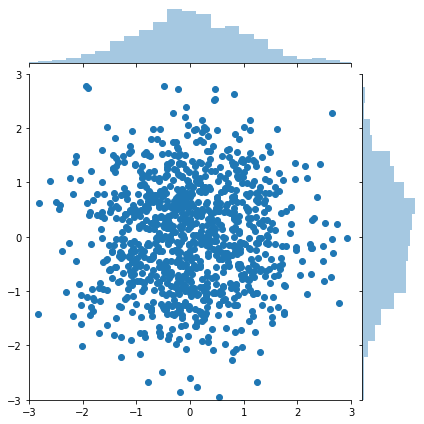

In [9]:
g = sns.jointplot(x, y, kind='scatter', xlim=(-3,3), ylim=(-3,3))
pass

### Generate univariate random normal deviates

In [10]:
@jit(nopython=True)
def box_muller(n):
    """Generate n random normal deviates."""
    
    u1 = np.random.random((n+1)//2)
    u2 = np.random.random((n+1)//2)
    r_squared = -2*np.log(u1)
    r = np.sqrt(r_squared)
    theta = 2*np.pi*u2
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    z = np.empty(n)
    z[:((n+1)//2)] = x
    z[((n+1)//2):] = y
    return z[:n]

### Generating multivariate normal random deviates

In [11]:
@jit(nopython=True)
def mvn(mu, sigma, n=1):
    """Generate n samples from multivarate normal with mean mu and covariance sigma."""
    
    A = np.linalg.cholesky(sigma)
    p = len(mu)
    
    zs = np.zeros((n, p))
    for i in range(n):
        z = box_muller(p)
        zs[i] = mu + A@z    
    return zs

In [12]:
mu = 4.0*np.ones(2)
sigma = np.array([[1,0.6], [0.6, 1]])

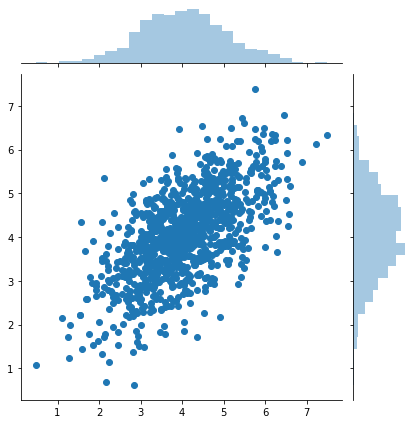

In [13]:
n = 1000
x, y = mvn(mu, sigma, n).T
g = sns.jointplot(x, y, kind='scatter')
pass

In [14]:
## Rejection sampling

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.
findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


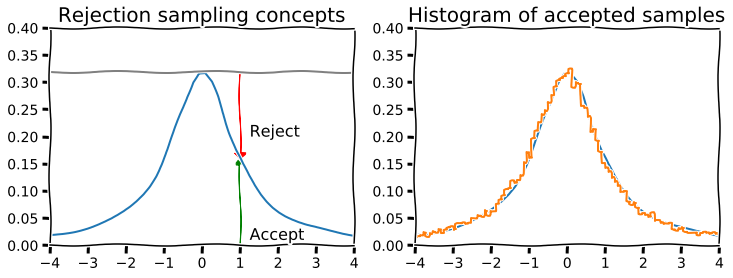

In [15]:
# Suppose we want to sample from the truncated Cauchy distribution 
# We use the uniform as a proposal distibution (highly inefficient)

x = np.linspace(-4, 4)

dist = stats.cauchy()
upper = dist.pdf(0)

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x, dist.pdf(x))
    plt.axhline(upper, color='grey')
    px = 1.0
    plt.arrow(px,0,0,dist.pdf(1.0)-0.01, linewidth=1,
              head_width=0.2, head_length=0.01, fc='g', ec='g')
    plt.arrow(px,upper,0,-(upper-dist.pdf(px)-0.01), linewidth=1, 
              head_width=0.3, head_length=0.01, fc='r', ec='r')
    plt.text(px+.25, 0.2, 'Reject', fontsize=16)
    plt.text(px+.25, 0.01, 'Accept', fontsize=16)
    plt.axis([-4,4,0,0.4])
    plt.title('Rejection sampling concepts', fontsize=20)

    plt.subplot(122)
    n = 100000
    # generate from sampling distribution
    u = np.random.uniform(-4, 4, n)
    # accept-reject criterion for each point in sampling distribution
    r = np.random.uniform(0, upper, n)
    # accepted points will come from target (Cauchy) distribution
    v = u[r < dist.pdf(u)]

    plt.plot(x, dist.pdf(x), linewidth=2)

    # Plot scaled histogram 
    factor = dist.cdf(4) - dist.cdf(-4)
    hist, bin_edges = np.histogram(v, bins=100, normed=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    plt.step(bin_centers, factor*hist, linewidth=2)

    plt.axis([-4,4,0,0.4])
    plt.title('Histogram of accepted samples', fontsize=20);

### Mixture representations

Sometimes, the target distribution from which we need to generate random numbers can be expressed as a mixture of "simpler" distributions that we already know how to sample from

$$
f(x) = \int{g(x\,|\,y)p(y) dy}
$$

For example, if $y$ is drawn from the $\chi_\nu^2$ distribution, then $\mathcal{N}(0, \nu/y)$ is a sample from the Student's T distribution with $\nu$ degrees of freedom.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  if sys.path[0] == '':


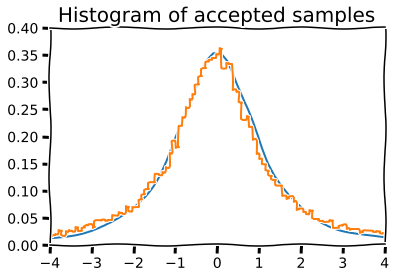

In [16]:
n = 10000
df = 2
dist = stats.t(df=df)
y = stats.chi2(df=df).rvs(n)
r = stats.norm(0, df/y).rvs(n)

with plt.xkcd():
    plt.plot(x, dist.pdf(x), linewidth=2)

    # Plot scaled histogram 
    factor = dist.cdf(4) - dist.cdf(-4)
    hist, bin_edges = np.histogram(v, bins=100, normed=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.
    plt.step(bin_centers, factor*hist, linewidth=2)

    plt.axis([-4,4,0,0.4])
    plt.title('Histogram of accepted samples', fontsize=20);

## Using `numpy.random`

### Setting seed for reproducibility

In [17]:
np.random.seed(123)

### Standard uniform

In [18]:
np.random.rand(3,4)

array([[0.69646919, 0.28613933, 0.22685145, 0.55131477],
       [0.71946897, 0.42310646, 0.9807642 , 0.68482974],
       [0.4809319 , 0.39211752, 0.34317802, 0.72904971]])

### Standard normal

In [19]:
np.random.randn(3, 4)

array([[-0.67888615, -0.09470897,  1.49138963, -0.638902  ],
       [-0.44398196, -0.43435128,  2.20593008,  2.18678609],
       [ 1.0040539 ,  0.3861864 ,  0.73736858,  1.49073203]])

### Parameterized distributions

Parameterized distribution functions typically have one or more of location, scale, shape or other parameters that can be specified.

#### Continuous  distributions

In [20]:
np.random.uniform(low=-1, high=1, size=(3, 4))

array([[ 0.44488677, -0.35408217, -0.27642269, -0.54347354],
       [-0.41257191,  0.26195225, -0.81579012, -0.13259765],
       [-0.13827447, -0.0126298 , -0.14833942, -0.37547755]])

In [21]:
np.random.normal(loc=100, scale=15, size=(3, 4))

array([[113.91193648,  97.39546476, 100.04268874, 110.32334067],
       [ 86.80695485, 104.25440986,  87.91950223,  74.08495759],
       [ 94.13650309, 108.60708794, 105.07883576,  99.82254258]])

In [22]:
np.random.standard_t(df=3, size=(3,4))

array([[ 2.26603603,  0.26443366, -2.62014171,  0.73989909],
       [ 0.52766961,  0.84688526, -0.63048839, -0.92233841],
       [ 1.15114019,  0.67780629,  0.82852178,  0.30139753]])

In [23]:
np.random.beta(a=0.5, b=0.5, size=(10,))

array([0.9853416 , 0.36941327, 0.17888099, 0.42376794, 0.12553194,
       0.32966061, 0.37205691, 0.39564619, 0.19150945, 0.83135736])

#### Discrete distributions

In [24]:
np.random.poisson(lam=10, size=(10,))

array([ 8,  8, 11, 15,  8,  7, 13, 12,  9,  9])

In [25]:
np.random.binomial(n=10, p=0.6, size=(10,))

array([8, 7, 4, 6, 6, 5, 5, 8, 5, 4])

In [26]:
np.random.negative_binomial(n=10, p=0.6, size=(10,))

array([10,  8,  3,  0,  6,  6,  4,  6,  3,  5])

In [27]:
np.random.geometric(p=0.6, size=(10,))

array([2, 1, 1, 5, 1, 1, 1, 4, 1, 2])

#### Multivariate distributions

In [28]:
np.random.multinomial(4, [0.1, 0.2, 0.3, 0.4], size=5)

array([[1, 0, 1, 2],
       [1, 0, 1, 2],
       [2, 1, 1, 0],
       [0, 0, 2, 2],
       [0, 3, 0, 1]])

In [29]:
np.random.multivariate_normal([10, 10], np.array([[3, 0.5], [0.5, 2]]), 5)

array([[12.36034662, 10.17775889],
       [10.59100147,  9.72067176],
       [ 9.14425098,  7.58936076],
       [12.13627781,  8.89252357],
       [11.98365842, 11.00145391]])

## Sampling with and without replacement

In [30]:
# Sampling is done with replacement by default
np.random.choice(4, 12)

array([1, 0, 1, 1, 0, 3, 0, 0, 0, 0, 2, 0])

In [31]:
# Probability weights can be given
np.random.choice(4, 12, p=[.4, .1, .1, .4])

array([0, 3, 0, 3, 3, 3, 3, 3, 1, 3, 0, 3])

In [32]:
x = np.random.randint(0, 10, (8, 12))
x

array([[7, 3, 1, 3, 9, 3, 6, 2, 3, 1, 9, 8],
       [0, 2, 3, 7, 9, 2, 7, 9, 7, 1, 4, 7],
       [4, 7, 8, 0, 2, 7, 4, 3, 7, 3, 7, 0],
       [7, 6, 8, 6, 8, 0, 5, 3, 2, 4, 3, 3],
       [9, 7, 1, 8, 0, 1, 4, 7, 2, 4, 8, 3],
       [4, 9, 6, 2, 7, 7, 7, 4, 7, 8, 4, 0],
       [7, 6, 3, 4, 1, 1, 7, 2, 7, 8, 9, 4],
       [4, 4, 7, 7, 9, 9, 4, 1, 5, 5, 8, 9]])

In [33]:
# sampling individual elements
np.random.choice(x.ravel(), 12)

array([1, 2, 7, 4, 7, 3, 8, 7, 7, 2, 4, 8])

In [34]:
# sampling rows
idx = np.random.choice(x.shape[0], 4)
x[idx, :]

array([[9, 7, 1, 8, 0, 1, 4, 7, 2, 4, 8, 3],
       [7, 6, 3, 4, 1, 1, 7, 2, 7, 8, 9, 4],
       [4, 9, 6, 2, 7, 7, 7, 4, 7, 8, 4, 0],
       [7, 6, 8, 6, 8, 0, 5, 3, 2, 4, 3, 3]])

In [35]:
# sampling columns
idx = np.random.choice(x.shape[1], 4)
x[:, idx]

array([[9, 6, 8, 8],
       [9, 7, 7, 7],
       [2, 4, 0, 0],
       [8, 5, 3, 3],
       [0, 4, 3, 3],
       [7, 7, 0, 0],
       [1, 7, 4, 4],
       [9, 4, 9, 9]])

#### Sampling without replacement

In [36]:
# Give the argument replace=False
try:
    np.random.choice(4, 12, replace=False)
except ValueError as e:
    print(e)

Cannot take a larger sample than population when 'replace=False'


## Shuffles, permutations and combinations

### Shuffle

Shuffle is an in-place permutation

In [37]:
xs = np.arange(10)
xs

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [38]:
np.random.shuffle(xs)
xs

array([1, 0, 8, 7, 3, 6, 4, 9, 5, 2])

Shuffle permutes rows of a matrix

In [39]:
xs = np.arange(12).reshape(3,4)
xs

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [40]:
np.random.shuffle(xs)
xs

array([[ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [ 0,  1,  2,  3]])

In [41]:
# To shuffle columns instead, transpose before shuffling
np.random.shuffle(x.T)
x

array([[1, 3, 2, 3, 9, 7, 1, 8, 3, 9, 3, 6],
       [3, 2, 9, 7, 9, 0, 1, 7, 2, 4, 7, 7],
       [8, 7, 3, 0, 2, 4, 3, 0, 7, 7, 7, 4],
       [8, 6, 3, 6, 8, 7, 4, 3, 0, 3, 2, 5],
       [1, 7, 7, 8, 0, 9, 4, 3, 1, 8, 2, 4],
       [6, 9, 4, 2, 7, 4, 8, 0, 7, 4, 7, 7],
       [3, 6, 2, 4, 1, 7, 8, 4, 1, 9, 7, 7],
       [7, 4, 1, 7, 9, 4, 5, 9, 9, 8, 5, 4]])

### Permutation

In [42]:
np.random.permutation(10)

array([1, 2, 3, 4, 7, 6, 5, 9, 8, 0])

In [43]:
# When given an integre n, permutation treats is as the array arange(n)
xs = np.arange(10)
np.random.permutation(xs)

array([6, 5, 2, 7, 4, 3, 9, 8, 1, 0])

In [44]:
xs = np.arange(12).reshape(3,4)
np.random.permutation(xs)

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [45]:
# Use indices if you needed to shuffle collections of arrays in synchrony
x = np.arange(12).reshape(4,3)
y = x + 10
idx = np.random.permutation(x.shape[0])
list(zip(x[idx, :], y[idx, :]))

[(array([0, 1, 2]), array([10, 11, 12])),
 (array([ 9, 10, 11]), array([19, 20, 21])),
 (array([3, 4, 5]), array([13, 14, 15])),
 (array([6, 7, 8]), array([16, 17, 18]))]

### Using `itertools`

In [46]:
list(map(lambda x: ''.join(x), it.permutations('abc')))

['abc', 'acb', 'bac', 'bca', 'cab', 'cba']

In [47]:
list(map(lambda x: ''.join(x), it.combinations('abcd', 3)))

['abc', 'abd', 'acd', 'bcd']

In [48]:
list(map(lambda x: ''.join(x), it.combinations_with_replacement('abcd', 2)))

['aa', 'ab', 'ac', 'ad', 'bb', 'bc', 'bd', 'cc', 'cd', 'dd']

### Leave one out

Unlike R, Python does not use negative indexing to delete items. So we need to create a Boolean index to create leave-one-out sequences.

In [49]:
x = np.arange(10, 15)
for i in range(len(x)):
    idx = np.arange(len(x)) != i
    print(x[idx])

[11 12 13 14]
[10 12 13 14]
[10 11 13 14]
[10 11 12 14]
[10 11 12 13]


## Using `scipy.stats`

### Example: modeling IQ

Suppose IQ is normally distributed with a mean of 0 and a standard deviation of 15.

In [50]:
dist = stats.norm(loc=100, scale=15)

#### Random variates

In [51]:
dist.rvs(10)

array([102.13638378, 108.11846946, 120.10148055,  76.46115809,
        92.34485689,  93.28342862, 114.06775446,  94.65005408,
        71.5723661 , 101.31595696])

In [52]:
xs = np.linspace(50, 150, 100)

#### PDF

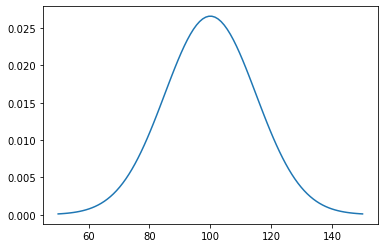

In [53]:
plt.plot(xs, dist.pdf(xs))
pass

#### CDF

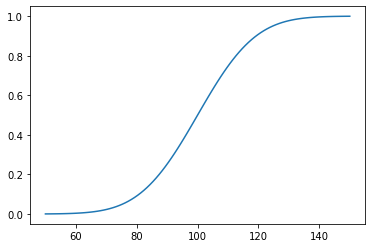

In [54]:
plt.plot(xs, dist.cdf(xs))
pass

#### Percentiles

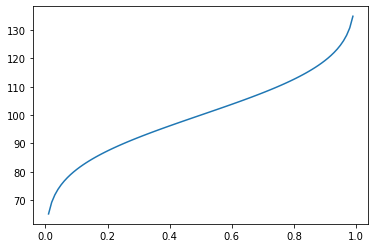

In [55]:
cdf = np.linspace(0, 1, 100)
plt.plot(cdf, dist.ppf(cdf))
pass

In [56]:
data = np.random.normal(110, 15, 100)

### Exercises

**1**. If your IQ is 138, what percentage of the population has a higher IQ?

In [57]:
dist = stats.norm(loc=100, scale=15)

In [58]:
100 * (1 - dist.cdf(138))

0.564917275556065

#### Via simulation

In [59]:
n = int(1e6)
samples = dist.rvs(n)

In [60]:
np.sum(samples > 138)/n

0.005694

**2**. If your IQ is at the 88th percentile, what is your IQ?

In [61]:
dist.ppf(0.88)

117.62480188099136

#### Via simulation

In [62]:
samples = np.sort(samples)
samples[int(0.88*n)]

117.6441801355916

**3**. What proportion of the population has IQ between 70 and 90?

In [63]:
dist.cdf(90) - dist.cdf(70)

0.2297424055987437

#### Via simulation

In [64]:
np.sum((samples > 70) & (samples < 90))/n

0.229644

#### MLE fit and confidence intervals

In [65]:
loc, scale = stats.norm.fit(data)
loc, scale

(108.25727900498485, 14.374033188248367)

In [66]:
dist = stats.norm(loc, scale)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  


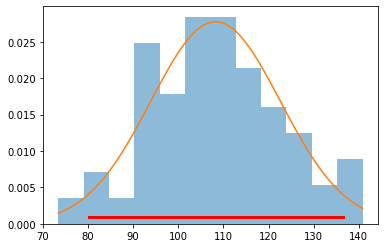

In [67]:
xs = np.linspace(data.min(), data.max(), 100)
plt.hist(data, 12, histtype='stepfilled', normed=True, alpha=0.5)
plt.plot(xs, dist.pdf(xs))
plt.plot(dist.interval(0.95), [0.001, 0.001], c='r', linewidth=3)
pass

## Sampling

### Without replication

In [68]:
np.random.choice(range(10), 5, replace=False)

array([7, 2, 3, 1, 6])

### With replication

In [69]:
np.random.choice(range(10), 15)

array([9, 4, 9, 9, 1, 0, 4, 1, 6, 8, 3, 0, 5, 4, 7])

### Example

- How often do we get a run of 5 or more consecutive heads in 100 coin tosses if we repeat the experiment 1000 times?
- What if the coin is biased to generate heads only 40% of the time?

In [70]:
expts = 1000
tosses = 100

#### We assume that 0 maps to T and 1 to H

In [71]:
xs = np.random.choice([0,1], (expts, tosses))

#### For biased coin

In [72]:
ys = np.random.choice([0,1], (expts, tosses), p=[0.6, 0.4])

#### Using a finite state machine

In [73]:
runs = 0
for x in xs:
    m = 0
    for i in x:
        if i == 1:
            m += 1
            if m >=5:
                runs += 1
                break
        else:
            m = 0
runs

796

#### Using `partitionby`

In [74]:
runs = 0
for x in xs:
    parts = tz.partitionby(lambda i: i==1, x)
    for part in parts:
        if part[0] == 1 and len(part) >= 5:
            runs += 1
            break
runs

796

#### Using sliding windows

In [75]:
runs = 0
for x in xs:
    for w in tz.sliding_window(5, x):
        if np.sum(w) == 5:
            runs += 1
            break
runs

796

#### Using a regular expression

In [76]:
xs = xs.astype('str')

In [77]:
runs = 0
for x in xs:
    if (re.search(r'1{5,}', ''.join(x))):
        runs += 1
runs

796